In [1]:
# loaddata.py

import json

def load_geojson(filename):
    # geojson_data_path = './testdata/' + filename + '.geojson'
    geojson_data_path = '../server/testdata/' + filename + '.geojson'

    try:
        with open(geojson_data_path, 'r') as file:
            data = json.load(file)
        return data
    except Exception as e:
        raise ValueError(f"An error occurred while loading the GeoJSON data: {e}")

def ship_ids_list(filename):
    data = load_geojson(filename)
    ship_ids = sorted({feature['properties']['SHIP_ID'] for feature in data['features']})
    return ship_ids

In [2]:
load_geojson('passenger_resample10T_ver03')

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'SHIP_ID': '123456788',
    'RECPTN_DT': '2022-08-12T01:30:00',
    'SEQUENCE_ID': 1,
    'SOG': 10.7,
    'COG': 96.8,
    'TYPE': 'passenger',
    'LEN_PRED': 6.25,
    'TON': 11.0,
    'dist': 148.67964567511444,
    'sea_lv': 182.0,
    'port_name': '이어도',
    'port_geometry': {'type': 'Point', 'coordinates': [125.16667, 32.11667]}},
   'geometry': {'type': 'Point', 'coordinates': [126.542485, 31.468265]}},
  {'type': 'Feature',
   'properties': {'SHIP_ID': '123456788',
    'RECPTN_DT': '2022-08-24T22:00:00',
    'SEQUENCE_ID': 2,
    'SOG': 5.3,
    'COG': 60.5,
    'TYPE': 'passenger',
    'LEN_PRED': 6.25,
    'TON': 11.0,
    'dist': 133.91085080078506,
    'sea_lv': 228.0,
    'port_name': '이어도',
    'port_geometry': {'type': 'Point', 'coordinates': [125.16667, 32.11667]}},
   'geometry': {'type': 'Point',
    'coordinates': [126.31339666666666, 31.409738333333333]}},
  {'type': 'Feature',
   'pr

In [3]:
ship_ids_list('passenger_resample10T_ver03')

['123456788',
 '209682000',
 '210326000',
 '229166000',
 '229416000',
 '229659000',
 '232036828',
 '256334000',
 '273199300',
 '308628000',
 '311000637',
 '312983000',
 '351280000',
 '351735000',
 '352001378',
 '352001473',
 '352001554',
 '352001576',
 '352001621',
 '352001759',
 '352212000',
 '352549000',
 '352605000',
 '352986205',
 '353059000',
 '354085000',
 '354344000',
 '354425000',
 '355319000',
 '355739000',
 '355925000',
 '355928000',
 '356644000',
 '356828000',
 '370216000',
 '371478000',
 '372009000',
 '372178000',
 '372424000',
 '372875000',
 '373116000',
 '373982000',
 '374869000',
 '412203360',
 '412418581',
 '412439271',
 '412549138',
 '412786000',
 '414472000',
 '431281000',
 '431302000',
 '431587000',
 '431600146',
 '431602232',
 '431833000',
 '432545000',
 '440000350',
 '440000540',
 '440000920',
 '440001090',
 '440001100',
 '440001130',
 '440001310',
 '440001360',
 '440001380',
 '440001420',
 '440001540',
 '440001700',
 '440002010',
 '440002030',
 '440002340',
 '4400

In [7]:
import json
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from datetime import datetime, timedelta

# Constants for conversion
METER_TO_DEGREE = 1 / 111.32  # Approximation for conversion (1 degree ≈ 111.32 km)

# Function to create an elliptical domain
def create_ellipse(center, semi_major, semi_minor, angle):
    return Ellipse(xy=(center.x, center.y), width=semi_major*2, height=semi_minor*2, angle=angle, edgecolor='blue', fc='none', lw=2)

# Function to calculate ships around an input ship using Coldwell model
def calculate_ships_around(geojson_data, ship_id, recptn_dt_str, time_length=10):
    # Parse the input datetime
    recptn_dt = datetime.fromisoformat(recptn_dt_str)

    # Find the specific ship's data
    ship_feature = next((feature for feature in geojson_data['features'] if feature['properties']['SHIP_ID'] == ship_id and datetime.fromisoformat(feature['properties']['RECPTN_DT']) == recptn_dt), None)
    
    if ship_feature is None:
        print(f"Ship ID {ship_id} at {recptn_dt} not found.")
        return

    # Extract ship details
    ship_position = Point(ship_feature['geometry']['coordinates'])
    sog = ship_feature['properties']['SOG']
    cog = ship_feature['properties']['COG']
    ship_length_meters = ship_feature['properties']['LEN_PRED']

    print('Current ship position:', ship_position)

    # Convert ship length from meters to degrees
    ship_length_degrees = ship_length_meters * METER_TO_DEGREE

    # Determine encounter type (assume crossing for this example, you can add logic to determine this)
    encounter_type = 'crossing'

    if encounter_type == 'overtaking':
        semi_major = 6 * ship_length_degrees
        semi_minor = 1.75 * ship_length_degrees
        shift_x = 0
        shift_y = 0
    else:  # head-on or crossing
        semi_major = 5 * ship_length_degrees
        semi_minor = 2.5 * ship_length_degrees
        shift_x = 0.75 * ship_length_degrees
        shift_y = 1.1 * ship_length_degrees

    print(f"Ellipse semi-major axis: {semi_major}, semi-minor axis: {semi_minor}")

    # Create the elliptical domain
    domain_center = Point(ship_position.x - shift_x, ship_position.y - shift_y)
    ellipse = create_ellipse(domain_center, semi_major, semi_minor, cog)

    print('Ellipse created at:', domain_center)

    # Define the time window
    start_time = recptn_dt
    end_time = recptn_dt + timedelta(minutes=time_length)

    print('timeline of focus: ', start_time, ' ~ ', end_time)

    # Filter ships within the time window
    filtered_features = [feature for feature in geojson_data['features'] if start_time <= datetime.fromisoformat(feature['properties']['RECPTN_DT']) <= end_time]

    print(f"Number of filtered ships: {len(filtered_features)}")

    # Find the closest ports at start time and end time
    closest_ports = []
    start_feature = next((feature for feature in filtered_features if datetime.fromisoformat(feature['properties']['RECPTN_DT']) == start_time), None)
    end_feature = next((feature for feature in filtered_features if datetime.fromisoformat(feature['properties']['RECPTN_DT']) == end_time), None)

    if start_feature:
        closest_ports.append(Point(start_feature['properties']['port_geometry']['coordinates']))
    if end_feature:
        closest_ports.append(Point(end_feature['properties']['port_geometry']['coordinates']))

    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the closest ports
    for port in closest_ports:
        plt.plot(port.x, port.y, 'bo', markersize=10)

    # Plot the elliptical domain
    ax.add_patch(ellipse)

    # Plot the input ship's position with a triangle marker
    plt.plot(ship_position.x, ship_position.y, 'ro', markersize=10)
    triangle = plt.Polygon(((ship_position.x, ship_position.y), 
                            (ship_position.x + 0.005, ship_position.y + 0.005), 
                            (ship_position.x - 0.005, ship_position.y + 0.005)), color='red')
    ax.add_patch(triangle)
    
    plt.title(f'Ship Collision Detection for SHIP_ID {ship_id} at {recptn_dt}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()

    return None

In [4]:
# Load and parse GeoJSON data
geojson_data = load_geojson('passenger_resample10T_ver03')

Current ship position: POINT (129.05724 35.104216666666666)
Ellipse semi-major axis: 0.3817822493711822, semi-minor axis: 0.1908911246855911
Ellipse created at: POINT (128.99997266259433 35.02022457180501)
timeline of focus:  2022-06-11 08:50:00  ~  2022-06-11 09:50:00
Number of filtered ships: 892


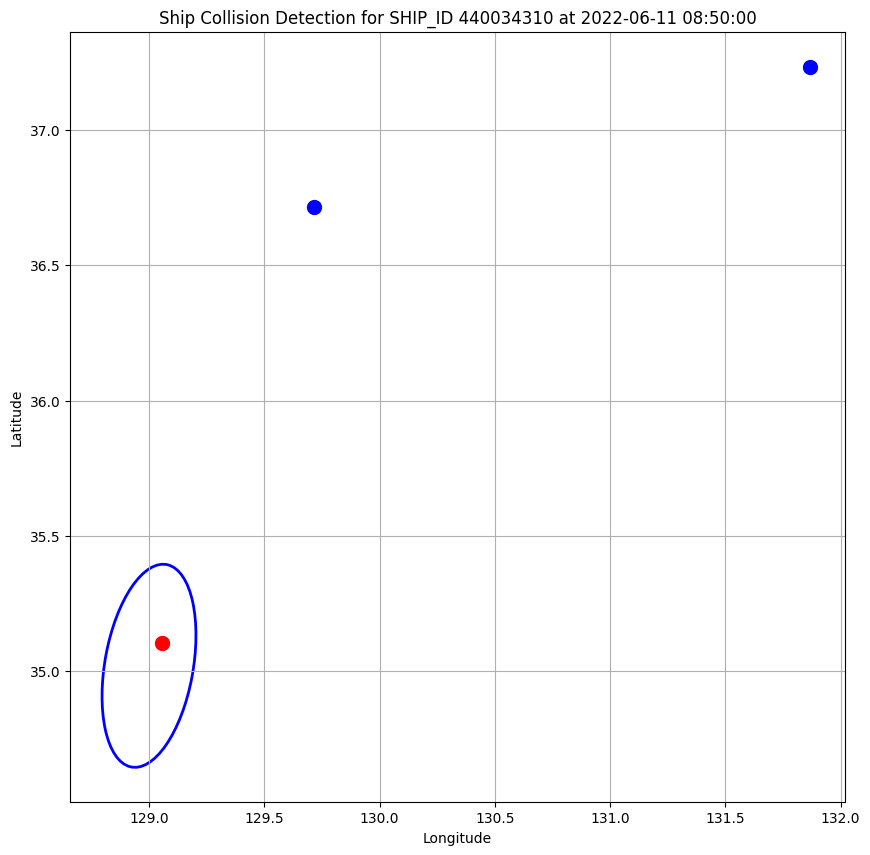

In [8]:
# Example usage
calculate_ships_around(geojson_data, '440034310', '2022-06-11T08:50:00', 60)

In [35]:
import json
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon as MplPolygon
import numpy as np
from datetime import datetime, timedelta

# Constants for conversion
METER_TO_DEGREE = 1 / 111320  # Approximation for conversion (1 degree ≈ 111.32 km)

# Function to create an elliptical domain
def create_ellipse(center, semi_major, semi_minor, angle):
    return Ellipse(xy=(center.x, center.y), width=semi_major*2, height=semi_minor*2, angle=angle, edgecolor='blue', fc='none', lw=2)

# Function to calculate ships around an input ship using Coldwell model
def calculate_ships_around(geojson_data, ship_id, recptn_dt_str, time_length=10):
    # Parse the input datetime
    recptn_dt = datetime.fromisoformat(recptn_dt_str)

    # Find the specific ship's data
    ship_feature = next((feature for feature in geojson_data['features'] if feature['properties']['SHIP_ID'] == ship_id and datetime.fromisoformat(feature['properties']['RECPTN_DT']) == recptn_dt), None)
    
    if ship_feature is None:
        print(f"Ship ID {ship_id} at {recptn_dt} not found.")
        return

    # Extract ship details
    ship_position = Point(ship_feature['geometry']['coordinates'])
    sog = ship_feature['properties']['SOG']
    cog = ship_feature['properties']['COG']
    ship_length_meters = ship_feature['properties']['LEN_PRED']

    print('Current ship position:', ship_position)

    # Convert ship length from meters to degrees
    ship_length_degrees = ship_length_meters * METER_TO_DEGREE

    # Determine encounter type (assume crossing for this example, you can add logic to determine this)
    encounter_type = 'crossing'

    if encounter_type == 'overtaking':
        semi_major = 6 * ship_length_degrees
        semi_minor = 1.75 * ship_length_degrees
        shift_x = 0
        shift_y = 0
    else:  # head-on or crossing
        semi_major = 5 * ship_length_degrees
        semi_minor = 2.5 * ship_length_degrees
        shift_x = 0.75 * ship_length_degrees
        shift_y = 1.1 * ship_length_degrees

    print(f"Ellipse semi-major axis: {semi_major}, semi-minor axis: {semi_minor}")

    # Create the elliptical domain
    domain_center = Point(ship_position.x - shift_x, ship_position.y - shift_y)
    ellipse = create_ellipse(domain_center, semi_major, semi_minor, cog)

    print('Ellipse created at:', domain_center)

    # Define the time window
    start_time = recptn_dt
    end_time = recptn_dt + timedelta(minutes=time_length)

    print('timeline of focus: ', start_time, ' ~ ', end_time)

    # Filter ships within the time window
    filtered_features = [feature for feature in geojson_data['features'] if start_time <= datetime.fromisoformat(feature['properties']['RECPTN_DT']) <= end_time]

    print(f"Number of filtered ships: {len(filtered_features)}")

    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the elliptical domain
    ax.add_patch(ellipse)

    # Function to create an equilateral triangle for the ship
    def create_triangle(center, length, angle):
        height = np.sqrt(3) / 2 * length * METER_TO_DEGREE  # Height of equilateral triangle in degrees
        base = height / 3  # Base of the isosceles triangle
        angle_rad = np.radians(angle)
        
        p1 = (center.x + height * np.cos(angle_rad), center.y + height * np.sin(angle_rad))
        p2 = (center.x + base * np.cos(angle_rad + np.pi / 2), center.y + base * np.sin(angle_rad + np.pi / 2))
        p3 = (center.x + base * np.cos(angle_rad - np.pi / 2), center.y + base * np.sin(angle_rad - np.pi / 2))
        
        print('triangle: ', p1, p2, p3)
        
        return MplPolygon([p1, p2, p3], closed=True, color='red')
    
    # Plot the input ship's position with a triangle marker
    triangle = create_triangle(ship_position, ship_length_meters, cog)
    ax.add_patch(triangle)
    
    plt.title(f'Ship Collision Detection for SHIP_ID {ship_id} at {recptn_dt}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    
    # Adjust the plot limits to show the actual latitude and longitude
    ax.set_xlim(ship_position.x - 0.001, ship_position.x + 0.001)
    ax.set_ylim(ship_position.y - 0.001, ship_position.y + 0.001)
    
    # Display the plot with adjusted limits to reflect actual coordinates
    plt.show()

    return None

Current ship position: POINT (129.05724 35.104216666666666)
Ellipse semi-major axis: 0.00038178224937118223, semi-minor axis: 0.00019089112468559112
Ellipse created at: POINT (129.0571827326626 35.1041326745718)
timeline of focus:  2022-06-11 08:50:00  ~  2022-06-11 09:50:00
Number of filtered ships: 892
triangle:  (129.05725419972254, 35.10428125070849) (129.05721847198606, 35.10422139990751) (129.05726152801395, 35.10421193342582)


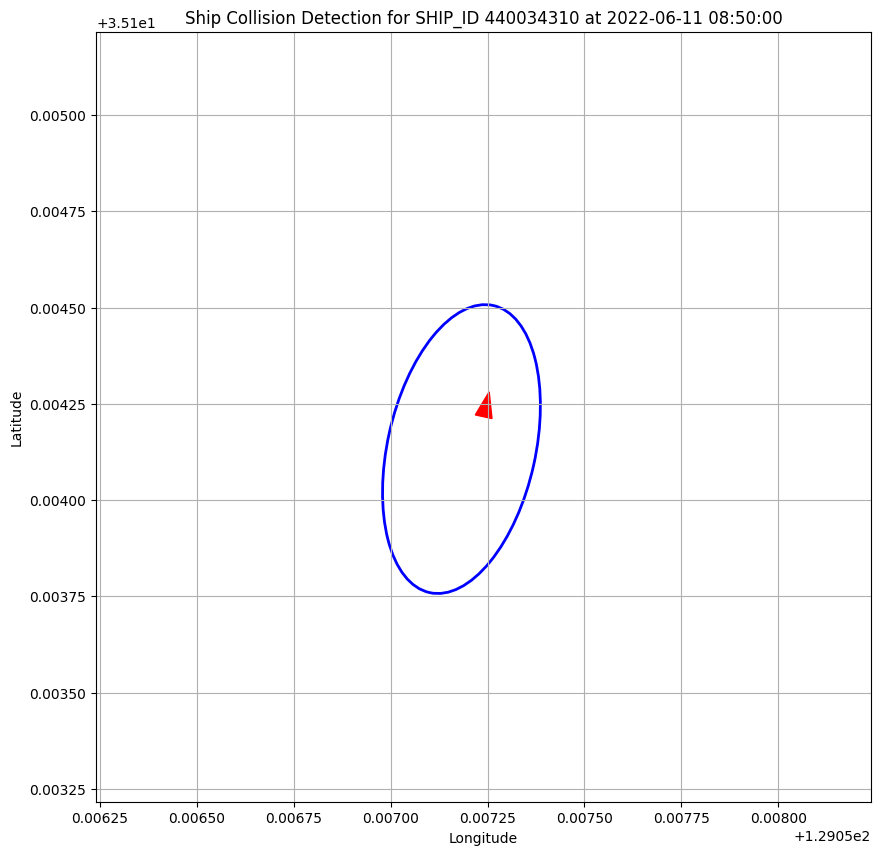

In [36]:
# Example usage
calculate_ships_around(geojson_data, '440034310', '2022-06-11T08:50:00', 60)

In [19]:
import json
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon as MplPolygon
import numpy as np
from datetime import datetime, timedelta

# Constants for conversion
METER_TO_DEGREE = 1 / 111320  # Approximation for conversion (1 degree ≈ 111.32 km)

# Function to create an elliptical domain
def create_ellipse(center, semi_major, semi_minor, angle):
    return Ellipse(xy=(center.x, center.y), width=semi_major*2, height=semi_minor*2, angle=angle, edgecolor='blue', fc='none', lw=2)

# Function to calculate ships around an input ship using Coldwell model
def calculate_ships_around(geojson_data, ship_id, recptn_dt_str, time_length=10, encounter_type='crossing'):
    # Parse the input datetime
    recptn_dt = datetime.fromisoformat(recptn_dt_str)

    # Find the specific ship's data at start time
    start_ship_feature = next((feature for feature in geojson_data['features'] if feature['properties']['SHIP_ID'] == ship_id and datetime.fromisoformat(feature['properties']['RECPTN_DT']) == recptn_dt), None)
    
    if start_ship_feature is None:
        print(f"Ship ID {ship_id} at {recptn_dt} not found.")
        return

    # Extract ship details at start time
    start_ship_position = Point(start_ship_feature['geometry']['coordinates'])
    start_cog = start_ship_feature['properties']['COG']
    ship_length_meters = start_ship_feature['properties']['LEN_PRED']

    print('Start ship position:', start_ship_position)

    # Find the specific ship's data at end time
    end_time = recptn_dt + timedelta(minutes=time_length)
    end_ship_feature = next((feature for feature in geojson_data['features'] if feature['properties']['SHIP_ID'] == ship_id and datetime.fromisoformat(feature['properties']['RECPTN_DT']) == end_time), None)
    
    if end_ship_feature is None:
        print(f"Ship ID {ship_id} at {end_time} not found.")
        return

    # Extract ship details at end time
    end_ship_position = Point(end_ship_feature['geometry']['coordinates'])
    end_cog = end_ship_feature['properties']['COG']
    print('End ship position:', end_ship_position)

    # Convert ship length from meters to degrees
    ship_length_degrees = ship_length_meters * METER_TO_DEGREE

    # Define Coldwell model dimensions for head-on and crossing encounters
    if encounter_type == 'overtaking':
        semi_major = 6 * ship_length_degrees
        semi_minor = 1.75 * ship_length_degrees
        shift_x = 0
        shift_y = 0
    else:  # head-on or crossing
        semi_major = 5 * ship_length_degrees
        semi_minor = 2.5 * ship_length_degrees
        shift_x = 0.75 * ship_length_degrees
        shift_y = 1.1 * ship_length_degrees

    print(f"Ellipse semi-major axis: {semi_major}, semi-minor axis: {semi_minor}")

    # Create the elliptical domains for start and end positions
    start_domain_center = Point(start_ship_position.x - shift_x, start_ship_position.y - shift_y)
    start_ellipse = create_ellipse(start_domain_center, semi_major, semi_minor, start_cog)

    end_domain_center = Point(end_ship_position.x - shift_x, end_ship_position.y - shift_y)
    end_ellipse = create_ellipse(end_domain_center, semi_major, semi_minor, end_cog)

    print('Start ellipse created at:', start_domain_center)
    print('End ellipse created at:', end_domain_center)

    # Function to create an isosceles triangle for the ship
    def create_triangle(center, length, angle):
        height = length * METER_TO_DEGREE  # Height of the triangle
        base = height / 3  # Base of the isosceles triangle
        angle_rad = np.radians(angle)
        
        p1 = (center.x + height * np.cos(angle_rad), center.y + height * np.sin(angle_rad))
        p2 = (center.x + base * np.cos(angle_rad + np.pi / 2), center.y + base * np.sin(angle_rad + np.pi / 2))
        p3 = (center.x + base * np.cos(angle_rad - np.pi / 2), center.y + base * np.sin(angle_rad - np.pi / 2))
        
        print('triangle: ', p1, p2, p3)
        
        return MplPolygon([p1, p2, p3], closed=True, color='red')
    
    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the elliptical domains
    ax.add_patch(start_ellipse)
    ax.add_patch(end_ellipse)

    # Plot the input ship's position with triangle markers
    start_triangle = create_triangle(start_ship_position, ship_length_meters, start_cog)
    end_triangle = create_triangle(end_ship_position, ship_length_meters, end_cog)
    ax.add_patch(start_triangle)
    ax.add_patch(end_triangle)
    
    plt.title(f'Ship Collision Detection for SHIP_ID {ship_id} from {recptn_dt} to {end_time}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    
    # Adjust the plot limits to show the actual latitude and longitude
    ax.set_xlim(min(start_ship_position.x, end_ship_position.x) - 0.001, max(start_ship_position.x, end_ship_position.x) + 0.001)
    ax.set_ylim(min(start_ship_position.y, end_ship_position.y) - 0.001, max(start_ship_position.y, end_ship_position.y) + 0.001)
    
    # Display the plot with adjusted limits to reflect actual coordinates
    plt.show()

    return None

Start ship position: POINT (129.05724 35.104216666666666)
End ship position: POINT (129.06772916666665 35.1013925)
Ellipse semi-major axis: 0.00038178224937118223, semi-minor axis: 0.00019089112468559112
Start ellipse created at: POINT (129.0571827326626 35.1041326745718)
End ellipse created at: POINT (129.06767189932924 35.10130850790514)
triangle:  (129.05725639642725, 35.10429124189453) (129.05721514159072, 35.10422213214241) (129.0572648584093, 35.10421120119092)
triangle:  (129.06776717164186, 35.10132627365103) (129.06775124211632, 35.10140516832507) (129.067707091217, 35.10137983167493)


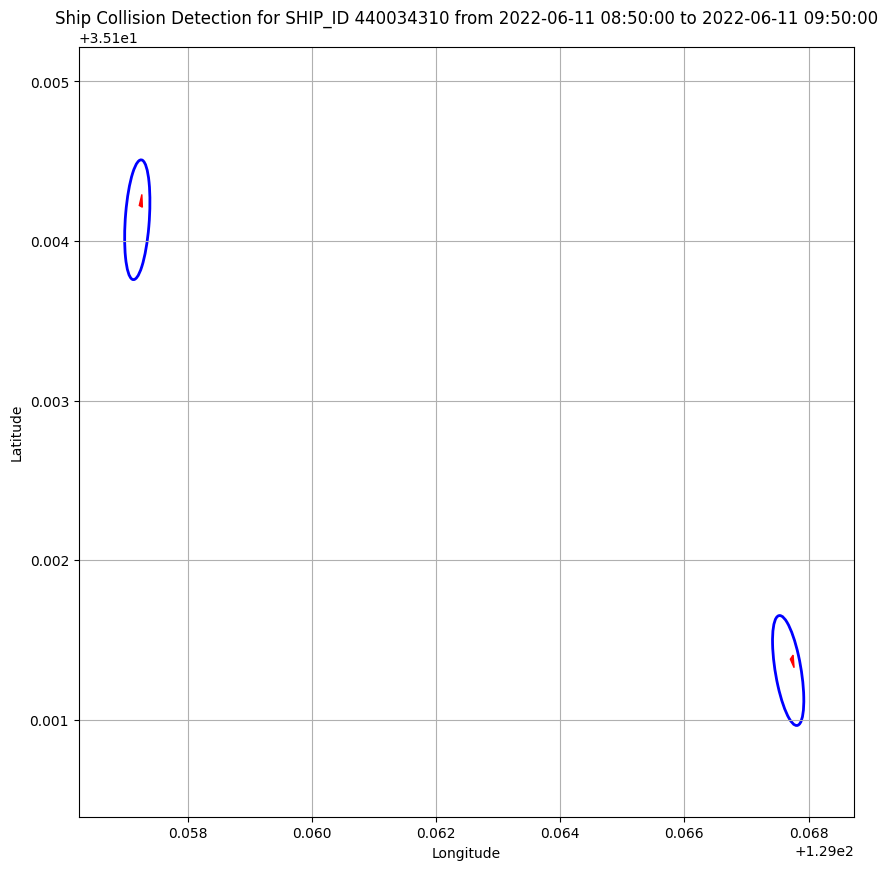

In [20]:
# Example usage
calculate_ships_around(geojson_data, '440034310', '2022-06-11T08:50:00', 60)

In [23]:
import json
from shapely.geometry import Point, Polygon, mapping
from datetime import datetime, timedelta

# Constants for conversion
METER_TO_DEGREE = 1 / 111320  # Approximation for conversion (1 degree ≈ 111.32 km)

# Function to calculate the elliptical domain
def create_ellipse(center, semi_major, semi_minor, angle):
    ellipse = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[]]
        },
        "properties": {
            "angle": angle
        }
    }
    num_points = 100
    for i in range(num_points):
        theta = 2.0 * 3.141592653589793 * float(i) / float(num_points)
        x = semi_major * np.cos(theta)
        y = semi_minor * np.sin(theta)
        ellipse["geometry"]["coordinates"][0].append([
            center.x + x * np.cos(np.radians(angle)) - y * np.sin(np.radians(angle)),
            center.y + x * np.sin(np.radians(angle)) + y * np.cos(np.radians(angle))
        ])
    ellipse["geometry"]["coordinates"][0].append(ellipse["geometry"]["coordinates"][0][0])  # Closing the ellipse
    return ellipse

# Function to create an isosceles triangle for the ship
def create_triangle(center, length, angle):
    height = length * METER_TO_DEGREE  # Height of the triangle
    base = height / 3  # Base of the isosceles triangle
    angle_rad = np.radians(angle)
    
    p1 = [center.x + height * np.cos(angle_rad), center.y + height * np.sin(angle_rad)]
    p2 = [center.x + base * np.cos(angle_rad + np.pi / 2), center.y + base * np.sin(angle_rad + np.pi / 2)]
    p3 = [center.x + base * np.cos(angle_rad - np.pi / 2), center.y + base * np.sin(angle_rad - np.pi / 2)]
    
    triangle = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[p1, p2, p3, p1]]  # Closing the triangle
        },
        "properties": {}
    }
    return triangle

# Function to calculate ships around an input ship using Coldwell model
def calculate_ships_around(geojson_data, ship_id, recptn_dt_str, time_length=10, encounter_type='crossing'):
    # Parse the input datetime
    recptn_dt = datetime.fromisoformat(recptn_dt_str)

    # Find the specific ship's data at start time
    start_ship_feature = next((feature for feature in geojson_data['features'] if feature['properties']['SHIP_ID'] == ship_id and datetime.fromisoformat(feature['properties']['RECPTN_DT']) == recptn_dt), None)
    
    if start_ship_feature is None:
        return {"error": f"Ship ID {ship_id} at {recptn_dt} not found."}

    # Extract ship details at start time
    start_ship_position = Point(start_ship_feature['geometry']['coordinates'])
    start_cog = start_ship_feature['properties']['COG']
    ship_length_meters = start_ship_feature['properties']['LEN_PRED']

    # Find the specific ship's data at end time
    end_time = recptn_dt + timedelta(minutes=time_length)
    end_ship_feature = next((feature for feature in geojson_data['features'] if feature['properties']['SHIP_ID'] == ship_id and datetime.fromisoformat(feature['properties']['RECPTN_DT']) == end_time), None)
    
    if end_ship_feature is None:
        return {"error": f"Ship ID {ship_id} at {end_time} not found."}

    # Extract ship details at end time
    end_ship_position = Point(end_ship_feature['geometry']['coordinates'])
    end_cog = end_ship_feature['properties']['COG']

    # Convert ship length from meters to degrees
    ship_length_degrees = ship_length_meters * METER_TO_DEGREE

    # Define Coldwell model dimensions for head-on and crossing encounters
    if encounter_type == 'overtaking':
        semi_major = 6 * ship_length_degrees
        semi_minor = 1.75 * ship_length_degrees
        shift_x = 0
        shift_y = 0
    else:  # head-on or crossing
        semi_major = 5 * ship_length_degrees
        semi_minor = 2.5 * ship_length_degrees
        shift_x = 0.75 * ship_length_degrees
        shift_y = 1.1 * ship_length_degrees

    # Create the elliptical domains for start and end positions
    start_domain_center = Point(start_ship_position.x - shift_x, start_ship_position.y - shift_y)
    start_ellipse = create_ellipse(start_domain_center, semi_major, semi_minor, start_cog)

    end_domain_center = Point(end_ship_position.x - shift_x, end_ship_position.y - shift_y)
    end_ellipse = create_ellipse(end_domain_center, semi_major, semi_minor, end_cog)

    # Create the triangles for start and end positions
    start_triangle = create_triangle(start_ship_position, ship_length_meters, start_cog)
    end_triangle = create_triangle(end_ship_position, ship_length_meters, end_cog)

    # Create GeoJSON output
    output = {
        "type": "FeatureCollection",
        "features": [
            start_ellipse,
            end_ellipse,
            start_triangle,
            end_triangle
        ]
    }

    return output

# Example usage for testing
if __name__ == "__main__":
    # # Load GeoJSON data from file
    # geojson_data_path = "path_to_your_geojson_file.geojson"
    # with open(geojson_data_path, 'r') as file:
    #     geojson_data = json.load(file)
    
    # Call the function and print the result
    result = calculate_ships_around(geojson_data, '440034310', '2022-06-11T08:50:00', 60)
    print(json.dumps(result, indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              129.05726471479883,
              35.104505550711124
            ],
            [
              129.05725284648256,
              35.1045073887757
            ],
            [
              129.05724070145905,
              35.104507748014505
            ],
            [
              129.05722832765923,
              35.10450662700979
            ],
            [
              129.05721577391674,
              35.10450403018564
            ],
            [
              129.05720308977556,
              35.10449996779054
            ],
            [
              129.0571903252941,
              35.1044944558569
            ],
            [
              129.05717753084807,
              35.104487516137816
            ],
            [
              129.05716475693117,
              35.10447917602

In [25]:
import json
from shapely.geometry import Point
from datetime import datetime, timedelta
import numpy as np

# Constants for conversion
METER_TO_DEGREE = 1 / 111320  # Approximation for conversion (1 degree ≈ 111.32 km)

# Function to calculate the elliptical domain
def create_ellipse(center, semi_major, semi_minor, angle):
    ellipse = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[]]
        },
        "properties": {
            "angle": angle
        }
    }
    num_points = 100
    for i in range(num_points):
        theta = 2.0 * 3.141592653589793 * float(i) / float(num_points)
        x = semi_major * np.cos(theta)
        y = semi_minor * np.sin(theta)
        ellipse["geometry"]["coordinates"][0].append([
            center.x + x * np.cos(np.radians(angle)) - y * np.sin(np.radians(angle)),
            center.y + x * np.sin(np.radians(angle)) + y * np.cos(np.radians(angle))
        ])
    ellipse["geometry"]["coordinates"][0].append(ellipse["geometry"]["coordinates"][0][0])  # Closing the ellipse
    return ellipse

# Function to create an isosceles triangle for the ship
def create_triangle(center, length, angle):
    height = length * METER_TO_DEGREE  # Height of the triangle
    base = height / 3  # Base of the isosceles triangle
    angle_rad = np.radians(angle)
    
    p1 = [center.x + height * np.cos(angle_rad), center.y + height * np.sin(angle_rad)]
    p2 = [center.x + base * np.cos(angle_rad + np.pi / 2), center.y + base * np.sin(angle_rad + np.pi / 2)]
    p3 = [center.x + base * np.cos(angle_rad - np.pi / 2), center.y + base * np.sin(angle_rad - np.pi / 2)]
    
    triangle = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[p1, p2, p3, p1]]  # Closing the triangle
        },
        "properties": {}
    }
    return triangle

# Function to calculate ships around an input ship using Coldwell model
def calculate_ships_around(geojson_data, ship_id, recptn_dt_str, time_length=10, encounter_type='crossing'):
    # Parse the input datetime
    recptn_dt = datetime.fromisoformat(recptn_dt_str)
    end_time = recptn_dt + timedelta(minutes=time_length)
    
    # Filter the features within the time window
    time_window_features = [
        feature for feature in geojson_data['features']
        if feature['properties']['SHIP_ID'] == ship_id
        and recptn_dt <= datetime.fromisoformat(feature['properties']['RECPTN_DT']) <= end_time
    ]
    
    if not time_window_features:
        return {"error": f"No data found for Ship ID {ship_id} within the time window {recptn_dt} to {end_time}."}

    # Define Coldwell model dimensions
    semi_major_factor = 5 if encounter_type != 'overtaking' else 6
    semi_minor_factor = 2.5 if encounter_type != 'overtaking' else 1.75
    shift_x_factor = 0.75 if encounter_type != 'overtaking' else 0
    shift_y_factor = 1.1 if encounter_type != 'overtaking' else 0

    features = []
    
    for feature in time_window_features:
        ship_position = Point(feature['geometry']['coordinates'])
        cog = feature['properties']['COG']
        ship_length_meters = feature['properties']['LEN_PRED']
        
        # Convert ship length from meters to degrees
        ship_length_degrees = ship_length_meters * METER_TO_DEGREE
        
        # Calculate dimensions
        semi_major = semi_major_factor * ship_length_degrees
        semi_minor = semi_minor_factor * ship_length_degrees
        shift_x = shift_x_factor * ship_length_degrees
        shift_y = shift_y_factor * ship_length_degrees
        
        # Create the elliptical domain
        domain_center = Point(ship_position.x - shift_x, ship_position.y - shift_y)
        ellipse = create_ellipse(domain_center, semi_major, semi_minor, cog)
        
        # Create the vessel triangle
        # triangle = create_triangle(ship_position, ship_length_meters, cog)
        
        # Add features to the collection
        features.append(ellipse)
        features.append(triangle)
    
    # Create GeoJSON output
    output = {
        "type": "FeatureCollection",
        "features": features
    }

    return output

# Example usage for testing
if __name__ == "__main__":
    # # Load GeoJSON data from file
    # geojson_data_path = "path_to_your_geojson_file.geojson"
    # with open(geojson_data_path, 'r') as file:
    #     geojson_data = json.load(file)
    
    # Call the function and print the result
    result = calculate_ships_around(geojson_data, '440034310', '2022-06-11T08:50:00', 30)
    print(json.dumps(result, indent=2))


{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              129.05726471479883,
              35.104505550711124
            ],
            [
              129.05725284648256,
              35.1045073887757
            ],
            [
              129.05724070145905,
              35.104507748014505
            ],
            [
              129.05722832765923,
              35.10450662700979
            ],
            [
              129.05721577391674,
              35.10450403018564
            ],
            [
              129.05720308977556,
              35.10449996779054
            ],
            [
              129.0571903252941,
              35.1044944558569
            ],
            [
              129.05717753084807,
              35.104487516137816
            ],
            [
              129.05716475693117,
              35.10447917602

In [ ]:
METER_TO_DEGREE = 1 / 111320  # Approximation for conversion (1 degree ≈ 111.32 km)

# elliptical domain
def create_ellipse(center, semi_major, semi_minor, angle):
    ellipse = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [[]]
        },
        "properties": {
            "angle": angle
        }
    }
    num_points = 100
    for i in range(num_points):
        theta = 2.0 * 3.141592653589793 * float(i) / float(num_points)
        x = semi_major * np.cos(theta)
        y = semi_minor * np.sin(theta)
        ellipse["geometry"]["coordinates"][0].append([
            center.x + x * np.cos(np.radians(angle)) - y * np.sin(np.radians(angle)),
            center.y + x * np.sin(np.radians(angle)) + y * np.cos(np.radians(angle))
        ])
    ellipse["geometry"]["coordinates"][0].append(ellipse["geometry"]["coordinates"][0][0])  # ellipse closing
    return ellipse


# Coldwell model
def calculate_ships_around(geojson_data, ship_id, recptn_dt_str, time_length=10, encounter_type='crossing'):
    recptn_dt = datetime.fromisoformat(recptn_dt_str)
    end_time = recptn_dt + timedelta(minutes=time_length)
    
    time_window_features = [
        feature for feature in geojson_data['features']
        if feature['properties']['SHIP_ID'] == ship_id
        and recptn_dt <= datetime.fromisoformat(feature['properties']['RECPTN_DT']) <= end_time
    ]
    
    if not time_window_features:
        return {"error": f"No data found for Ship ID {ship_id} within the time window {recptn_dt} to {end_time}."}

    # Coldwell model dimensions
    semi_major_factor = 5 if encounter_type != 'overtaking' else 6
    semi_minor_factor = 2.5 if encounter_type != 'overtaking' else 1.75
    shift_x_factor = 0.75 if encounter_type != 'overtaking' else 0
    shift_y_factor = 1.1 if encounter_type != 'overtaking' else 0

    features = []
    
    for feature in time_window_features:
        ship_position = Point(feature['geometry']['coordinates'])
        cog = feature['properties']['COG']
        ship_length_meters = feature['properties']['LEN_PRED']
        
        # ship length from meters to degrees
        ship_length_degrees = ship_length_meters * METER_TO_DEGREE
        
        # dimensions
        semi_major = semi_major_factor * ship_length_degrees
        semi_minor = semi_minor_factor * ship_length_degrees
        shift_x = shift_x_factor * ship_length_degrees
        shift_y = shift_y_factor * ship_length_degrees
        
        # elliptical domain
        domain_center = Point(ship_position.x - shift_x, ship_position.y - shift_y)
        ellipse = create_ellipse(domain_center, semi_major, semi_minor, cog)
        
        features.append(ellipse)
    
    # GeoJSON output
    output = {
        "type": "FeatureCollection",
        "features": features
    }

    return output

In [42]:
import json
from datetime import datetime, timedelta

def load_geojson_selected(filename, recptn_dt_str):
    geojson_data_path = '../server/testdata/' + filename + '.geojson'
    try:
        with open(geojson_data_path, 'r') as file:
            data = json.load(file)

            if recptn_dt_str:
                try:
                    # Remove 'Z' if it exists to match the format in your GeoJSON data
                    if recptn_dt_str.endswith('Z'):
                        recptn_dt_str = recptn_dt_str[:-5]
                    
                    recptn_dt = datetime.fromisoformat(recptn_dt_str)

                    # Directly compare the datetime strings
                    time_filtered_features = [
                        feature for feature in data['features']
                        if datetime.fromisoformat(feature['properties']['RECPTN_DT']) == recptn_dt
                    ]
                    data['features'] = time_filtered_features
                    print(f"Filtered features count: {len(time_filtered_features)}")
                except ValueError as e:
                    raise ValueError(f"Invalid datetime format: {e}")

        return data

    except ValueError as e:
        raise ValueError(f"An error occurred while loading the GeoJSON data: {e}")

result = load_geojson_selected('passenger_resample10T_ver03', '2022-06-11T08:50:00.000Z')
print(json.dumps(result, indent=2))

In [37]:
load_geojson('passenger_resample10T_ver03')

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'SHIP_ID': '123456788',
    'RECPTN_DT': '2022-08-12T01:30:00',
    'SEQUENCE_ID': 1,
    'SOG': 10.7,
    'COG': 96.8,
    'TYPE': 'passenger',
    'LEN_PRED': 6.25,
    'TON': 11.0,
    'dist': 148.67964567511444,
    'sea_lv': 182.0,
    'port_name': '이어도',
    'port_geometry': {'type': 'Point', 'coordinates': [125.16667, 32.11667]}},
   'geometry': {'type': 'Point', 'coordinates': [126.542485, 31.468265]}},
  {'type': 'Feature',
   'properties': {'SHIP_ID': '123456788',
    'RECPTN_DT': '2022-08-24T22:00:00',
    'SEQUENCE_ID': 2,
    'SOG': 5.3,
    'COG': 60.5,
    'TYPE': 'passenger',
    'LEN_PRED': 6.25,
    'TON': 11.0,
    'dist': 133.91085080078506,
    'sea_lv': 228.0,
    'port_name': '이어도',
    'port_geometry': {'type': 'Point', 'coordinates': [125.16667, 32.11667]}},
   'geometry': {'type': 'Point',
    'coordinates': [126.31339666666666, 31.409738333333333]}},
  {'type': 'Feature',
   'pr

In [44]:
result = load_geojson_selected('passenger_resample10T_ver03', '2022-06-11T08:50:00.000Z')
print(json.dumps(result, indent=2))

Filtered features count: 128
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "SHIP_ID": "353059000",
        "RECPTN_DT": "2022-06-11T08:50:00",
        "SEQUENCE_ID": 8,
        "SOG": 14.5,
        "COG": 45.3,
        "TYPE": "passenger",
        "LEN_PRED": 31.431404958677685,
        "TON": 9599.0,
        "dist": 117.58786953951302,
        "sea_lv": 17.0,
        "port_name": "\uc655\ub3cc\ucd08",
        "port_geometry": {
          "type": "Point",
          "coordinates": [
            129.71667,
            36.71667
          ]
        }
      },
      "geometry": {
        "type": "Point",
        "coordinates": [
          130.95075666666668,
          36.34921
        ]
      }
    },
    {
      "type": "Feature",
      "properties": {
        "SHIP_ID": "354344000",
        "RECPTN_DT": "2022-06-11T08:50:00",
        "SEQUENCE_ID": 5,
        "SOG": 5.180701754385964,
        "COG": 96.84736842105264,
       